<a href="https://colab.research.google.com/github/valerio-unifei/ECOM09A/blob/main/ECOM09A_2024_1_Atividade_2_Etapa_3_PARCIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECOM09A Atividade 2 Etapa 3

[Proposta](https://docs.google.com/document/d/e/2PACX-1vS-DZIR4CM_abUC7bgTtd3x5X_QCdh8Y3FdVdEQbTfTRricAduuQK5i_yQIHdMoKddV6g9QONtp-BuN/pub)

(07/06/2024) Usar método GloVe(Atualizado):
- GloVe em Português: http://nilc.icmc.usp.br/embeddings
- Exemplo de código: How to Detect Fake and Real News with Natural Language Processing

## Configuração

In [ ]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers

## Preparando Base de Dados

Baseado no exemplo do Keras:

https://keras.io/examples/nlp/pretrained_word_embeddings/

### Base de dados de artigos da Folha UOL

In [ ]:
import os
from IPython.core.display import display, HTML
from google.colab import files, userdata

display(HTML('<h1>Acessando Base de Dados</h1>'))

if not os.path.exists('/content/articles.csv'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  display(HTML('<h2>Baixando base do Kaggle</h2>'))
  !kaggle datasets download 'marlesson/news-of-the-site-folhauol'
  display(HTML('<h3>Descompactando base ...</h3>'))
  !unzip -qq news-of-the-site-folhauol.zip
  !rm news-of-the-site-folhauol.zip
display(HTML('<h2>Base pronta para uso</h2>'))

In [ ]:
import pandas as pd
display(HTML('<h1>Carregando base em DataFrame(df_folha)</h1>'))
df_folha = pd.read_csv('articles.csv',encoding="utf8")
display(HTML('<h2>Removendo colunas desnecessárias: ["title","date","subcategory","link"]</h2>'))
df_folha.drop(["title","date","subcategory","link"],axis=1,inplace=True)
display(HTML(f'<h3>Linhas atuais: {len(df_folha)}</h2>'))
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)
df_folha.reset_index(drop=True,inplace=True)
display(HTML(f'<h3>Linhas atualizadas: {len(df_folha)}</h2>'))
display(HTML('<h2>Selecionando apenas as categorias relevantes para classificação</h2>'))
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

targets, class_names = pd.factorize(df_folha['category'],sort=True)

samples = df_folha['text'].values
labels = pd.get_dummies(targets,dtype='int').values

print('Categorias:',class_names)
df_folha.drop(["category"],axis=1,inplace=True)
df_folha['target'] = targets
df_folha.head()
del df_folha

Categorias: Index(['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo',
       'poder'],
      dtype='object')


<ipython-input-40-28ca0db73829>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folha.drop(["category"],axis=1,inplace=True)
<ipython-input-40-28ca0db73829>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folha['target'] = targets


## Misturando e dividindo dados de treinamento e validação

In [ ]:
import numpy as np
# Misturando
display(HTML('<h1>Misturando e separando dados para treinamento</h1>'))
rng = np.random.RandomState(42)
rng.shuffle(samples)
rng = np.random.RandomState(42) # faz a mesma mistura do anterior
rng.shuffle(labels)
# extraindo treinamento e validacao
parte_analisada = min(??????,len(samples)) # problemas de RAM
display(HTML(f'<h3>Redução devido a RAM: {parte_analisada}</h1>'))
val_split = 0.2
val_num = int(val_split * parte_analisada)

samples_train = samples[:parte_analisada-val_num]
y_train = labels[:parte_analisada-val_num]

samples_val = samples[parte_analisada-val_num:parte_analisada]
y_val = labels[parte_analisada-val_num:parte_analisada]

display(HTML(f'<h3>Treinamento: {samples_train.shape[0]} Validação {samples_val.shape[0]}</h1>'))

## Vetorizando o Texto

In [ ]:
import tensorflow.data as tf_data

display(HTML('<h1>Vetorizando texto pelo conjunto de treinamento</h1>'))

dim_vetor = 200
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=dim_vetor)
text_ds = tf_data.Dataset.from_tensor_slices(samples_train).batch(128)
vectorizer.adapt(text_ds)

vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'de', 'a', 'o']

In [ ]:
output = vectorizer([["inteligência artificial dor de cabeça"]])
output.numpy()[0, :5]

array([ 2116, 12858,  2270,     2,   899])

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

test = ["inteligência", "artificial", "dor", "de", "cabeça"]
[word_index[w] for w in test]

[2116, 12858, 2270, 2, 899]

## GloVe - Global Vectors para Palavras

Fonte do modelo pré-treinado:

[Núcleo Interinstitucional de Linguística Computacional - USP](http://nilc.icmc.usp.br/embeddings)

In [ ]:
display(HTML('<h1>GloVe da USP - glove_s50</h1>'))

glove_file = "glove_s50.txt"

if not os.path.exists('glove_s50.txt'):
  !wget -O glove_s50.zip http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s50.zip
  !unzip -qq glove_s50.zip
  !rm glove_s50.zip

embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

display(HTML(f'<h2>Encontrado {len(embeddings_index)} vetores de palavras</h2>'))

<ipython-input-71-1f64dee8ae7b>:14: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


In [ ]:
num_tokens = len(voc) + 2
glove_vetor_tam = 50 # glove_s50 < 50
hits = 0
misses = 0
embedding_matrix = np.zeros((num_tokens, glove_vetor_tam))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:glove_vetor_tam]
        hits += 1
    else:
        misses += 1

display(HTML(f'<h2>Convertidas {hits} palavras ({misses} perdidas)</h2>'))

### Convertendo GloVe do treinamento para modelo Neural

In [ ]:
from keras import layers

embedding_layer = layers.Embedding(num_tokens, glove_vetor_tam, trainable=False)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

display(HTML('<h1>Camada com GloVe</h1>'))

## Modelo Neural

In [ ]:
# IMPLEMENTAR AQUI

### Treinamento

In [ ]:
X_train = vectorizer(np.array([[s] for s in samples_train])).numpy()
X_val = vectorizer(np.array([[s] for s in samples_val])).numpy()

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

display(HTML('<h1>Compilando Modelo Neural</h1>'))

model.compile(loss="?????????????", optimizer="rmsprop", metrics=["acc"])

display(HTML('<h1>Treinando</h1>'))
epochs = 20
history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val))

(4000, 200) (4000, 7) (1000, 200) (1000, 7)


Epoch 1/20
32/32 [==============================] - 12s 307ms/step - loss: 1.9302 - acc: 0.2062 - val_loss: 1.8254 - val_acc: 0.2050
Epoch 2/20
32/32 [==============================] - 6s 171ms/step - loss: 1.5691 - acc: 0.4000 - val_loss: 1.3300 - val_acc: 0.4740
Epoch 3/20
32/32 [==============================] - 5s 157ms/step - loss: 1.3074 - acc: 0.5297 - val_loss: 1.1872 - val_acc: 0.5630
Epoch 4/20
32/32 [==============================] - 8s 258ms/step - loss: 1.1100 - acc: 0.6183 - val_loss: 1.0332 - val_acc: 0.6140
Epoch 5/20
32/32 [==============================] - 7s 214ms/step - loss: 0.9648 - acc: 0.6768 - val_loss: 1.0196 - val_acc: 0.5780
Epoch 6/20
32/32 [==============================] - 5s 143ms/step - loss: 0.8690 - acc: 0.7007 - val_loss: 1.1406 - val_acc: 0.6140
Epoch 7/20
32/32 [==============================] - 6s 188ms/step - loss: 0.8010 - acc: 0.7278 - val_loss: 0.7571 - val_acc: 0.7240
Epoch 8/20
32/32 [==============================] - 9s 270ms/step - loss: 0

### Avaliando Modelo

Text(0.5, 1.0, 'Accuracy')

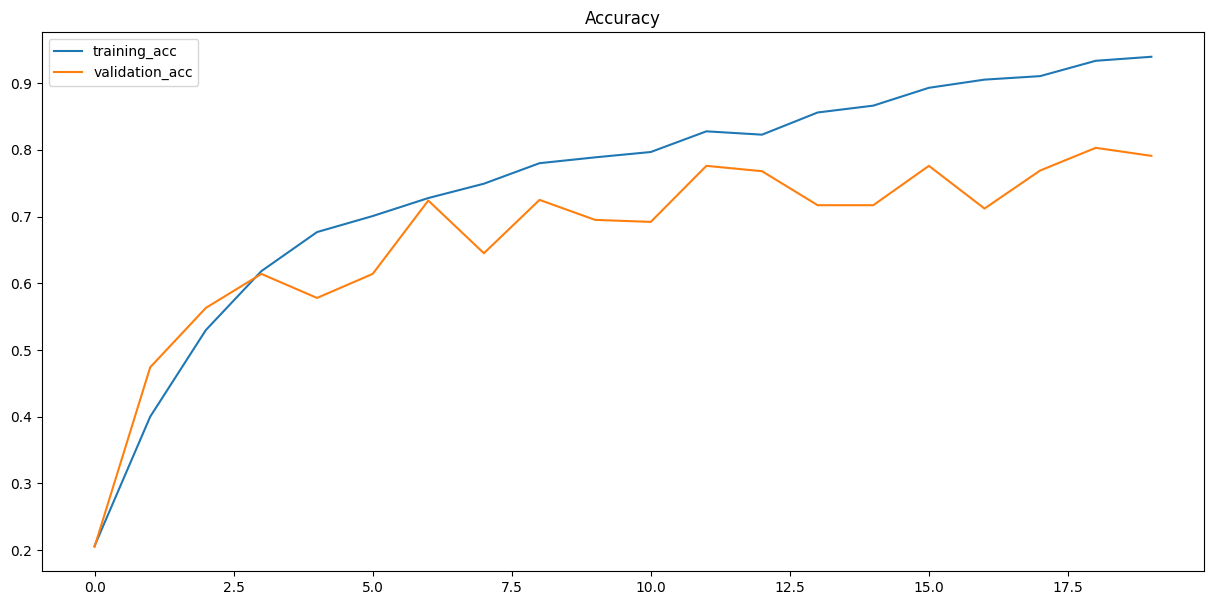

In [ ]:
import matplotlib.pyplot as plt

#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['acc'])
plt.plot(range(epochs), history.history['val_acc'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [ ]:
train_results = model.evaluate(X_train, np.asarray(y_train), verbose=0, batch_size=256)
test_results = model.evaluate(X_val, np.asarray(y_val), verbose=0, batch_size=256)
print(f'Train accuracy: {train_results[1]*100:0.2f}')
print(f'Test accuracy: {test_results[1]*100:0.2f}')

Train accuracy: 98.20
Test accuracy: 79.10


32/32 [==============================] - 1s 24ms/step


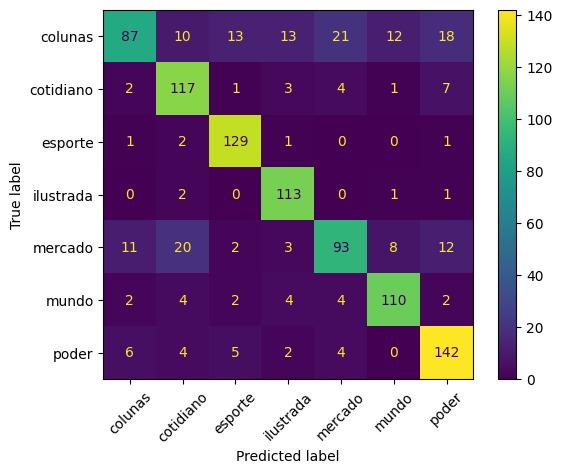

In [ ]:
output_val = model.predict(X_val)
y_pred_val = output_val.argmax(1)
y_real_val = y_val.argmax(1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_real_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)